#### Manual testing...

This notebook serves as an integration test to confirm that the model is behaving as we expect.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
MODEL_DIR = os.path.realpath(os.path.dirname('..\superscript_model'))
sys.path.append(os.path.normpath(MODEL_DIR))

In [3]:
from superscript_model import model
from superscript_model.utilities import Random

In [4]:
abm = model.SuperScriptModel(1000)

In [5]:
steps = range(1000)
active_projects = []
team_size = []

for step in steps:
    #print(step)
    abm.step()
    
    size = 0
    active_projects.append(abm.inventory.active_count)
    
    for project in abm.inventory.projects.values():
        size += len(project.team.members)
    team_size.append(size/len(abm.inventory.projects.values()))

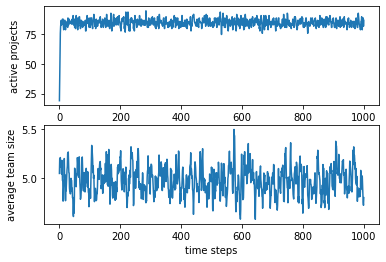

In [6]:
plt.subplot(2,1,1)
plt.plot(steps, active_projects)
plt.ylabel('active projects')

plt.subplot(2,1,2)
plt.plot(steps, team_size)
plt.xlabel('time steps')
plt.ylabel('average team size');

In [7]:
print(np.mean(active_projects[200:]))
print(np.mean(team_size[200:]))

85.015
4.976771518576126


#### We now select a random worker from the model and inspect the worker:

This produces a json formatted text summary of the worker. Note that this representation will be updated when we add in the worker's history and project activities.

In [8]:
random_worker = Random.choice(abm.schedule.agents)

print(random_worker.skills.to_string())

{
    "Worker OVR": 15.5,
    "Hard skills": [
        0.0,
        0.9,
        1.5,
        0.6,
        0.0
    ],
    "Soft skills": [
        4.4,
        4.6,
        1.9,
        0.5,
        3.8
    ],
    "Hard skill probability": 0.8,
    "OVR multiplier": 20
}


#### We now do the same for a randomly selected project..

In [9]:
random_project = Random.choice(list(abm.inventory.projects.values()))

In [10]:
print(random_project.requirements.to_string())

{
    "risk": 10,
    "creativity": 3,
    "flexible_budget": false,
    "max_budget_increase": 0.25,
    "p_hard_skill_required": 0.8,
    "min_skill_required": 2,
    "per_skill_cap": 10,
    "total_skill_units": 10,
    "hard_skills": {
        "A": {
            "level": 2,
            "units": 2
        },
        "B": {
            "level": 2,
            "units": 4
        },
        "C": {
            "level": 3,
            "units": 1
        },
        "D": {
            "level": 1,
            "units": 1
        },
        "E": {
            "level": 2,
            "units": 2
        }
    }
}


#### For this project we can also inspect the Team:

### Note: here the team of 5 is doing its best to meet the high skill unit requirements...Check with Michael. 

In [11]:
print(random_project.team.to_string())

{
    "project": 19920,
    "members": [
        408,
        202,
        329,
        73,
        11
    ],
    "lead": 11,
    "team_ovr": 67.4,
    "skill_balance": 0,
    "skill_contributions": {
        "A": [
            329,
            73
        ],
        "B": [
            408,
            11,
            73,
            329
        ],
        "C": [
            329
        ],
        "D": [
            202
        ],
        "E": [
            408,
            11
        ]
    }
}


In [26]:
random_project = Random.choice(list(abm.inventory.projects.values()))

In [27]:
print(random_project.requirements.to_string())

{
    "risk": 5,
    "creativity": 5,
    "flexible_budget": false,
    "max_budget_increase": 0.25,
    "p_hard_skill_required": 0.8,
    "min_skill_required": 2,
    "per_skill_cap": 10,
    "total_skill_units": 40,
    "hard_skills": {
        "A": {
            "level": 3,
            "units": 4
        },
        "B": {
            "level": 3,
            "units": 9
        },
        "C": {
            "level": 5,
            "units": 9
        },
        "D": {
            "level": 2,
            "units": 9
        },
        "E": {
            "level": 1,
            "units": 9
        }
    }
}


#### For this project we can also inspect the Team:

### Note: here the team of 5 is doing its best to meet the high skill unit requirements...Check with Michael. 

In [28]:
print(random_project.team.to_string())

{
    "project": 19953,
    "members": [
        259,
        269,
        670,
        686,
        959
    ],
    "lead": 670,
    "team_ovr": 47.9,
    "skill_balance": 36.2,
    "skill_contributions": {
        "A": [
            670,
            686,
            269,
            259
        ],
        "B": [
            269,
            686,
            670,
            959,
            259
        ],
        "C": [
            269,
            686,
            670,
            959,
            259
        ],
        "D": [
            670,
            269,
            259,
            686,
            959
        ],
        "E": [
            670,
            686,
            959,
            259,
            269
        ]
    }
}


#### Note that allocating the total skill units across the skills in a robust way was a non-trivial problem! Solved as follows...

*(Move this to another notebook).*

Select 5 numbers in (1,10) that sum to X, where X <=50
Always a = max(a,1) and b = min(b,10)
-	Select n1 randint(a,b) where a = X – (4\*10) and b = X – (4\*1)
-	Select n2 randint(a,b) where a = X – n1 – (3\*10) and b = X – n1 – (3\*1)
-	Select n3 randint(a,b) where a = X – n1 – n2 – (2\*10) and b = X – n1 – n2 – (2\*1)
-	…
-	Select n5 randint(a,b) where a = X – n1 – n2 – n3 – n4 and b = X – n1 – n2 – n3 – n4


In [12]:
def generate_skills(total):

    min_units = 1
    max_units = 10

    remaining = total
    length = 5

    assert total <= length*max_units
    assert total >= length*min_units

    skills = []

    for i in range(length):

        a = remaining - (length - (i+1))*max_units
        a = max(a, min_units)

        b = remaining - (length - (i+1))*min_units
        b = min(b, max_units)

        n = Random.randint(a,b)
        skills.append(n)
        remaining -= n
        
    assert sum(skills) == total
    return skills

In [13]:
for t in np.arange(5,50):
    print(generate_skills(t), "; sum = ", t)

[1, 1, 1, 1, 1] ; sum =  5
[1, 1, 2, 1, 1] ; sum =  6
[1, 3, 1, 1, 1] ; sum =  7
[1, 1, 4, 1, 1] ; sum =  8
[2, 4, 1, 1, 1] ; sum =  9
[5, 1, 2, 1, 1] ; sum =  10
[6, 1, 2, 1, 1] ; sum =  11
[2, 2, 6, 1, 1] ; sum =  12
[6, 2, 3, 1, 1] ; sum =  13
[9, 1, 2, 1, 1] ; sum =  14
[5, 2, 3, 2, 3] ; sum =  15
[1, 3, 3, 2, 7] ; sum =  16
[7, 2, 3, 2, 3] ; sum =  17
[7, 5, 4, 1, 1] ; sum =  18
[2, 4, 7, 4, 2] ; sum =  19
[4, 7, 5, 2, 2] ; sum =  20
[2, 6, 5, 6, 2] ; sum =  21
[7, 5, 1, 3, 6] ; sum =  22
[10, 4, 1, 2, 6] ; sum =  23
[2, 9, 5, 3, 5] ; sum =  24
[10, 6, 6, 1, 2] ; sum =  25
[9, 7, 8, 1, 1] ; sum =  26
[9, 2, 4, 5, 7] ; sum =  27
[3, 8, 10, 5, 2] ; sum =  28
[3, 1, 9, 7, 9] ; sum =  29
[8, 4, 6, 7, 5] ; sum =  30
[7, 10, 8, 1, 5] ; sum =  31
[7, 6, 7, 10, 2] ; sum =  32
[6, 6, 7, 4, 10] ; sum =  33
[8, 4, 3, 9, 10] ; sum =  34
[7, 1, 7, 10, 10] ; sum =  35
[4, 9, 5, 8, 10] ; sum =  36
[9, 1, 10, 7, 10] ; sum =  37
[4, 5, 10, 10, 9] ; sum =  38
[3, 7, 10, 10, 9] ; sum =  39
[10, 7, 1